# Neural Network 2: ReLU and 초기값 정하기 (2006/2007 breakthrough) 

## 참조 강의: 

홍콩 과기대 김성훈 교수님의 강의 내용 중 강좌 10번의 실습을 따라해 본다.

- [lab10: 딥러닝으로 MNIST 98%이상 해보기](https://youtu.be/ls8jHqRnEQk)



In [1]:
%pylab inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# anaconda에 설치된 tensorflow 예제 mnist example에 대한 경로명을 추가한다.
import sys
sys.path.insert(1, '/root/anaconda2/lib/python2.7/site-packages/tensorflow/examples/tutorials/mnist')



Populating the interactive namespace from numpy and matplotlib


In [2]:
## Part 1: 이미지 데이터 로드
# -----------------------------
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print mnist.train.labels[0:5, :]

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [4]:
# http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
def xavier_init(n_inputs, n_outputs, uniform=True):
  """Set the parameter initialization using the method described.
  This method is designed to keep the scale of the gradients roughly the same
  in all layers.
  Xavier Glorot and Yoshua Bengio (2010):
           Understanding the difficulty of training deep feedforward neural
           networks. International conference on artificial intelligence and
           statistics.
  Args:
    n_inputs: The number of input nodes into each output.
    n_outputs: The number of output nodes for each input.
    uniform: If true use a uniform distribution, otherwise use a normal.
  Returns:
    An initializer.
  """
  if uniform:
    # 6 was used in the paper.
    init_range = math.sqrt(6.0 / (n_inputs + n_outputs))
    return tf.random_uniform_initializer(-init_range, init_range)
  else:
    # 3 gives us approximately the same limits as above since this repicks
    # values greater than 2 standard deviations from the mean.
    stddev = math.sqrt(3.0 / (n_inputs + n_outputs))
    return tf.truncated_normal_initializer(stddev=stddev)

In [5]:
"""
W1 = tf.get_variable("W1", shape=[784, 10], initializer=xavier_init(784, 10)) 에서
Did you mean to set reuse=True in VarScope? 오류 발생 시... 
http://stackoverflow.com/questions/36218823/char-rnn-in-tensorflow 참조
"""
tf.reset_default_graph()


## Part 2: 변수, 가설함수, cost function 및 gradient descent 정의
# ----------------------------------------------------------------
# 변수 선언
X = tf.placeholder(tf.float32, [None, 784], name="inputX") # bias term 제외, 하나의 이미지는 28x28이다.
Y = tf.placeholder(tf.float32, [None, 10], name="inputY") # one-hot encoding 때문에 10개로 선언한다.

# 1개의 hidden layer를 갖는 3 layer Neural Network를 정의한다.
# 모델의 파라미터 선언
"""
W1 = tf.Variable(tf.random_uniform([784, 256], -1.0, 1.0), name="Weight1")
W2 = tf.Variable(tf.random_uniform([256, 256], -1.0, 1.0), name="Weight2")
W3 = tf.Variable(tf.random_uniform([256, 10], -1.0, 1.0), name="Weight3")
"""


# ------------------------------------------------
# Xavier 를 이용한 시도
# ------------------------------------------------
#"""
W1 = tf.get_variable("W1", shape=[784, 256], initializer=xavier_init(784, 256))
W2 = tf.get_variable("W2", shape=[256, 256], initializer=xavier_init(256, 256))
W3 = tf.get_variable("W3", shape=[256, 256], initializer=xavier_init(256, 256))
W4 = tf.get_variable("W4", shape=[256, 256], initializer=xavier_init(256, 256))
W5 = tf.get_variable("W5", shape=[256, 10], initializer=xavier_init(256, 10))
#"""

b1 = tf.Variable(tf.random_uniform([256], -1.0, 1.0), name="Bias1")
b2 = tf.Variable(tf.random_uniform([256], -1.0, 1.0), name="Bias2")
b3 = tf.Variable(tf.random_uniform([256], -1.0, 1.0), name="Bias3")
b4 = tf.Variable(tf.random_uniform([256], -1.0, 1.0), name="Bias3")
b5 = tf.Variable(tf.random_uniform([10], -1.0, 1.0), name="Bias3")


learning_rate = tf.Variable(0.003)

# ------------------------------------------------
# sigmoid 를 이용한 시도
# ------------------------------------------------
"""
L2 = tf.sigmoid(tf.matmul(X, W1) + b1)
L3 = tf.sigmoid(tf.matmul(L2, W2) + b2)
hypothesis = tf.sigmoid(tf.matmul(L3, W3) + b3) # 가설함수 정의
cost = -tf.reduce_mean(Y*tf.log(hypothesis) + (1-Y)*tf.log(1-hypothesis)) # cost function 정의
optimizer = tf.train.GradientDescentOptimizer(learning_rate) # optimize cost
train = optimizer.minimize(cost)
"""

# ------------------------------------------------
# relu 를 이용한 시도
# ------------------------------------------------
"""
L2 = tf.nn.relu(tf.matmul(X, W1) + b1)
L3 = tf.nn.relu(tf.matmul(L2, W2) + b2)
hypothesis = tf.matmul(L3, W3) + b3 # 가설함수 정의, relu를 사용할 필요 없다.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(hypothesis, Y)) # cost function 정의
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
"""

# ------------------------------------------------
# relu + more deep & dropout
# ------------------------------------------------
#"""
dropout_rate = tf.placeholder("float")
_L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(_L1, dropout_rate)
_L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(_L2, dropout_rate)
_L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(_L3, dropout_rate)
_L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(_L4, dropout_rate)

hypothesis = tf.matmul(L4, W5) + b5 # 가설함수 정의, relu를 사용할 필요 없다.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(hypothesis, Y)) # cost function 정의
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#"""


    
# tensorboard step 1: histogram 추가
w1_hist = tf.histogram_summary("w1_hist", W1)
w2_hist = tf.histogram_summary("w2_hist", W2)
w3_hist = tf.histogram_summary("w3_hist", W3)
b1_hist = tf.histogram_summary("b1_hist", b1)
b2_hist = tf.histogram_summary("b2_hist", b2)
b3_hist = tf.histogram_summary("b3_hist", b3)

 

### sigmoid 적용

아래와 같이 구성한다.

- 3 layer
- learning_rate = 3.0
- hypothesis = tf.sigmoid(tf.matmul(L3, W3) + b3)
- cost = -tf.reduce_mean(Y*tf.log(hypothesis) + (1-Y)*tf.log(1-hypothesis))

test set의 accuracy = 92.65%

### relu 적용

- learning_rate = 0.03
- L3 = tf.nn.relu(tf.matmul(L2, W2) + b2)
- hypothesis = tf.matmul(L3, W3) + b3 # 가설함수 정의, relu를 사용할 필요 없다.
- cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(hypothesis, Y)) # cost function 정의
- train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

test set의 accuracy = 93.91%


### Xavier 초기화 적용

- W1 = tf.get_variable("W1", shape=[784, 256], initializer=xavier_init(784, 256))

test set accuracy = 97.00%

### more deep & dropout

- layer 5개 사용
- xavier 초기화 사용
- dropout 사용

test set accuracy = 98.13%


Epoch: 0001 , cost =  0.376060677 
Epoch: 0002 , cost =  0.199629387 
Epoch: 0003 , cost =  0.164182898 
Epoch: 0004 , cost =  0.148201066 
Epoch: 0005 , cost =  0.144980516 
Epoch: 0006 , cost =  0.135722203 
Epoch: 0007 , cost =  0.139414541 
Epoch: 0008 , cost =  0.131870273 
Epoch: 0009 , cost =  0.123009865 
Epoch: 0010 , cost =  0.119346424 
Epoch: 0011 , cost =  0.119971928 
Epoch: 0012 , cost =  0.122470589 
Epoch: 0013 , cost =  0.124614979 
Epoch: 0014 , cost =  0.116911333 
Epoch: 0015 , cost =  0.121315484 
Epoch: 0016 , cost =  0.110711080 
Epoch: 0017 , cost =  0.109653256 
Epoch: 0018 , cost =  0.111416301 
Epoch: 0019 , cost =  0.107888220 
Epoch: 0020 , cost =  0.105665296 
Optimizaiton finishied.


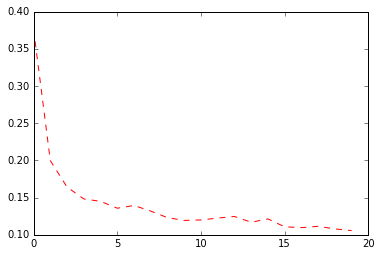

In [8]:
## Part 3: training dataset
# batch로 트레이닝한다.
# ------------------------------

# tensorboard step 2: 모든 summary를 통합한다.
merged = tf.merge_all_summaries()
#merged = tf.merge_summary([w1_hist, w2_hist, b1_hist, b2_hist, y_hist])


# 변수 초기화 및 그래프 시작
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# tensorboard step 3: writer를 생성한다.
writer = tf.train.SummaryWriter("./logs/test", sess.graph_def)


# Using small batches of random data is called stochastic training
# 작은 배치 사이즈로 트레이닝한다. 이것은 stochastic training이라고도 한다.
# 전체 데이터로 하면 정확도가 높긴하지만, 비용이 많이 든다. 

# 아래 변수들을 적당히 조정해야 한다.
training_epochs = 20 # 전체 트레이닝 반복 횟수 20
batch_size = 100 # 한 번에 처리하는 데이터 사이즈 100
display_step = 1 # progress 표시 
arr_J = np.zeros(training_epochs) # cost 저장

total_batch = int(mnist.train.num_examples / batch_size)

# training 반복횟수만큼 루프실행
for epoch in range(training_epochs):
    avg_cost = 0;
    
    # 전체 배치 수를 결정하고 각 배치에 대해서 루프를 실행한다.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(train, feed_dict={X: batch_xs, Y: batch_ys, dropout_rate: 0.7})
    
        # cost를 계산한다.
        avg_cost += sess.run(cost, \
            feed_dict = {X: batch_xs, Y: batch_ys, dropout_rate: 0.7}) / total_batch

    # tensorboard step 4: merged와 add_summary를 실행한다.
    #summary = sess.run(merged, feed_dict={X: batch_xs, Y: batch_ys}) # placehoder관련 오류 발생        
    #writer.add_summary(summary, epoch)
    
    if epoch % display_step == 0:
        print "Epoch: %04d" % (epoch + 1), ", cost = ", "{:.9f} ".format(avg_cost)
    
    # cost를 plot한다.
    arr_J[epoch] = avg_cost

print "Optimizaiton finishied."
plot(arr_J, 'r--')




Label:  [9]
Prediction:  [9]


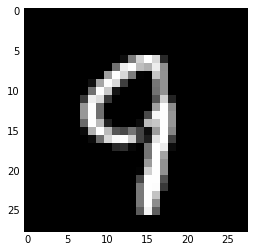

Accuracy:  97.7699995041


In [9]:
## Part 4: Predict & Show
# test set에서 임의로 하나의 이미지를 선택하고 예측한다.
# -----------------------------------------------------
# image를 보여준다.
r = randint(0, mnist.test.num_examples - 1)
# XXX: labels[r:r+1] 은 2차원 배열(행렬)로 반환한다. labels[r]은 1차원 벡터를 반환한다.
print "Label: ", sess.run(tf.argmax(mnist.test.labels[r:r+1], 1))
print "Prediction: ", sess.run(tf.argmax(hypothesis, 1), \
            feed_dict = {X: mnist.test.images[r:r+1], dropout_rate: 1.0})

# 이미지 출력
#plt.set_cmap('gray')
plt.imshow(mnist.test.images[r:r+1].reshape(28, 28), cmap="gray", interpolation="nearest")
plt.show()



## Part 4: test set에 대한 모델의 정확도를 계산한다.
# -----------------------------------------------------

# Test 모델 구축
# activation은 모델이 예측한 값을 가지고 있고, Y는 실제 label의 값이다.
# tf.argmax() 함수는 임의의 축(가로 또는 세로)에 대한 가장 높은 값을 갖는 인덱스를 반환한다.
correct_prediction = tf.equal(tf.argmax(hypothesis,1), tf.argmax(Y,1))

# correct_prediction은 [True, False]와 같은 boolean 값을 갖는다. float으로 형변환 하면
# 1, 0 으로 바뀌게 되고 평균을 취한다.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 정확도를 계산한다.
print "Accuracy: ", sess.run(accuracy, \
        feed_dict={X: mnist.test.images, Y: mnist.test.labels, dropout_rate: 1.0}) * 100
#print "Accuracy: ", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels})



149 Label:  [2] Prediction:  [3]


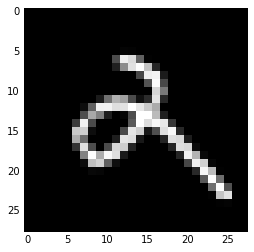

151 Label:  [9] Prediction:  [5]


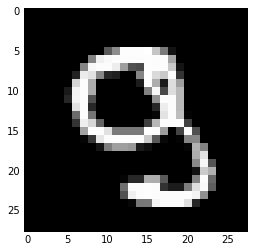

241 Label:  [9] Prediction:  [5]


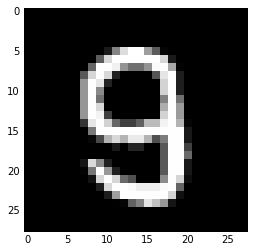

247 Label:  [4] Prediction:  [2]


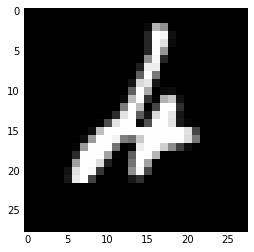

259 Label:  [6] Prediction:  [0]


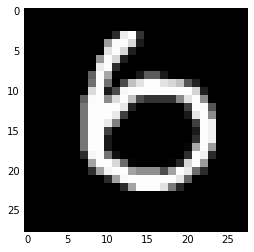

274 Label:  [9] Prediction:  [3]


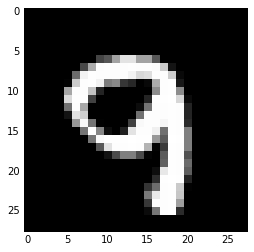

321 Label:  [2] Prediction:  [7]


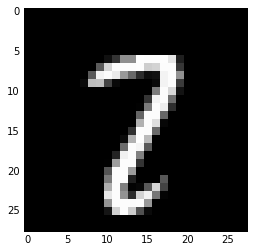

447 Label:  [4] Prediction:  [9]


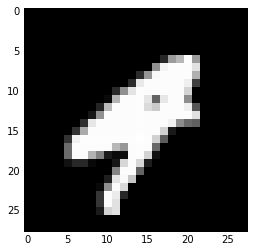

479 Label:  [9] Prediction:  [5]


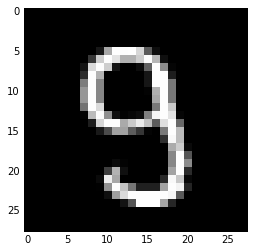

552 Label:  [0] Prediction:  [6]


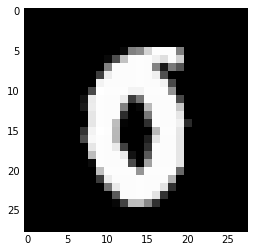

582 Label:  [8] Prediction:  [2]


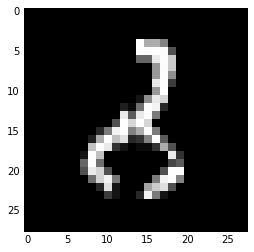

583 Label:  [2] Prediction:  [8]


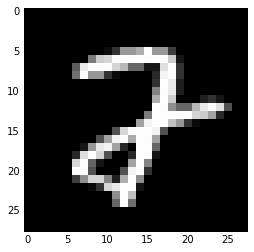

610 Label:  [4] Prediction:  [8]


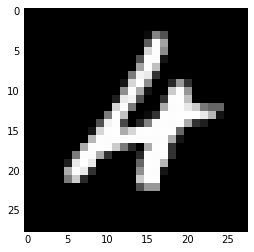

659 Label:  [2] Prediction:  [7]


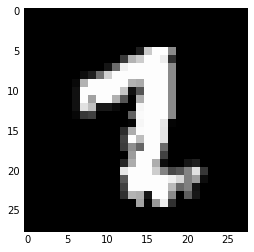

674 Label:  [5] Prediction:  [3]


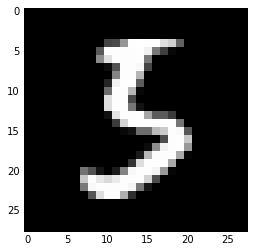

684 Label:  [7] Prediction:  [3]


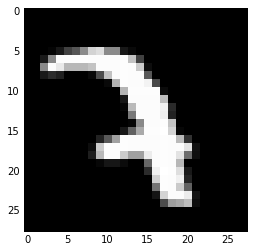

691 Label:  [8] Prediction:  [4]


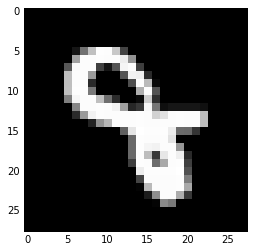

707 Label:  [4] Prediction:  [9]


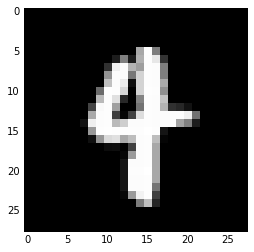

717 Label:  [0] Prediction:  [6]


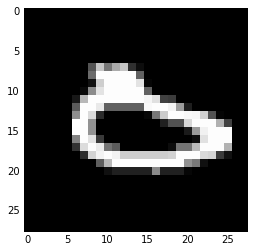

720 Label:  [5] Prediction:  [8]


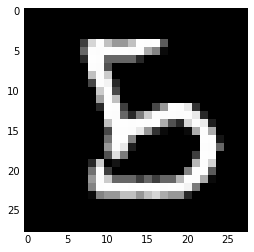

740 Label:  [4] Prediction:  [9]


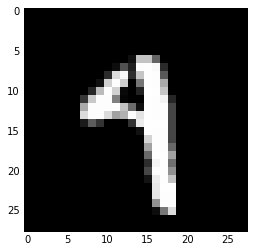

844 Label:  [8] Prediction:  [7]


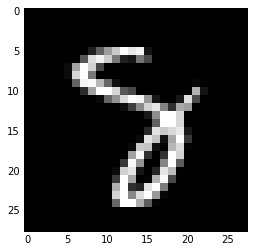

1014 Label:  [6] Prediction:  [5]


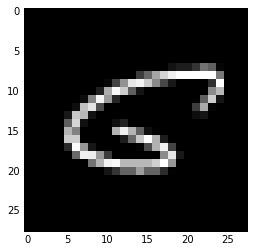

1032 Label:  [5] Prediction:  [6]


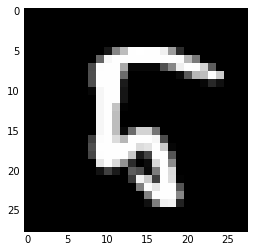

1039 Label:  [7] Prediction:  [1]


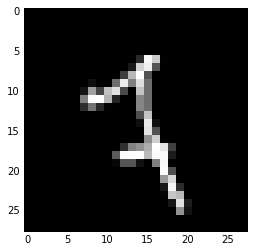

In [ ]:
# XXX: labels[r:r+1] 은 2차원 배열(행렬)로 반환한다. labels[r]은 1차원 벡터를 반환한다.
# 모든 test set을 예측하고 틀린 결과에 대해서 이미지를 살펴본다.
for r in xrange(mnist.test.num_examples):
    label = sess.run(tf.argmax(mnist.test.labels[r:r+1], 1))
    prediction = sess.run(tf.argmax(hypothesis, 1), \
            feed_dict = {X: mnist.test.images[r:r+1], dropout_rate: 1.0})

    # 틀릴 경우 이미지를 표시한다.
    if label != prediction:
        print r, "Label: ", label, "Prediction: ", prediction
    
        # 이미지 출력
        #plt.set_cmap('gray')
        plt.imshow(mnist.test.images[r:r+1].reshape(28, 28), cmap="gray", interpolation="nearest")
        plt.show()

print "done!"
